In [16]:
from plot import Plot, PointsCollection, LinesCollection, Scene
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc


In [17]:
from typing import Optional
from voronoiV2 import Voronoi
from dataTypes import Point


"""
Inspiration:
https://github.com/pvigier/FortuneAlgorithm/blob/master/src/FortuneAlgorithm.cpp
"""

class VoronoiVisualization(Voronoi):
    def __init__(self, points: set[Point], steps = True):
        super().__init__(points)
        self.visualization = None  # type: Optional[Visualization]
        self.steps = steps

    def addVisualization(self, visualization: 'Visualization'):
        self.visualization = visualization

    def solve(self):
        while self.events.empty() is False:
            y, p = self.events.get()
            
            if p in self.notValidEvents:
                continue
                          
            if p in self.points:
                self.handleSiteEvent(p)
            else:
                self.handleCircleEvent(p)
                if self.visualization is not None and self.steps is True:
                    self.visualization.drawCircleEvent(p)
                
            if self.visualization is not None and self.steps is True:
                self.visualization.newScene()
                self.visualization.addSweep(p)
                self.visualization.addVoronoiVertices()
                self.visualization.addVoronoiEdges()
                self.visualization.dravBeachLine(p)
                self.visualization.drawCircles()
                
        self.endHalfEdges()
        
        if self.steps is False and self.visualization is not None:
            self.visualization.newScene()
            self.visualization.addVoronoiVertices()
            self.visualization.addVoronoiEdges()

    def endHalfEdges(self):
        leftArc = self.beachLine.minimum(voronoi.beachLine.root)
        rightArc = leftArc.next
        while rightArc is not None:
            test = leftArc.rightHalfEdge.end
            if test is not None and (test.x < self.lowerLeft.x or test.x > self.upperRight.x or \
                test.y < self.lowerLeft.y or test.y > self.upperRight.y):
                
                leftArc = rightArc
                rightArc = rightArc.next
                continue
    
            x = (leftArc.point.x + rightArc.point.x) / 2
            y = (leftArc.point.y + rightArc.point.y) / 2
    
            tmpPoint = Point(x, y)
    
            diffX = leftArc.point.x - rightArc.point.x
            diffY = leftArc.point.y - rightArc.point.y
    
            orientation = Point(-diffY, diffX)
    
            intersection = self.getIntersectionWithBox(tmpPoint, orientation)
            self.vertices.add(intersection)
    
            leftArc.rightHalfEdge.start = intersection
            rightArc.leftHalfEdge.end = intersection
            
            if self.visualization is not None and self.steps is True:
                self.visualization.newScene()
                self.visualization.addVoronoiEdges()
                self.visualization.addVoronoiVertices()
            leftArc = rightArc
            rightArc = rightArc.next

In [18]:
class Visualization:
    def __init__(self, voronoi: Voronoi):
        self.scenes = []
        self.points = voronoi.points
        self.events = voronoi.events
        self.beachLine = voronoi.beachLine
        self.notValidEvents = voronoi.notValidEvents
        self.vertices = voronoi.vertices
        self.listEdges = voronoi.listEdges
        self.lowerLeft = voronoi.lowerLeft
        self.upperRight = voronoi.upperRight

        
        self.bounds = []
        self.bounds.append([[self.lowerLeft.x, self.lowerLeft.y], [self.lowerLeft.x, self.upperRight.y]])
        self.bounds.append([[self.lowerLeft.x, self.upperRight.y], [self.upperRight.x, self.upperRight.y]])
        self.bounds.append([[self.upperRight.x, self.upperRight.y], [self.upperRight.x, self.lowerLeft.y]])
        self.bounds.append([[self.upperRight.x, self.lowerLeft.y], [self.lowerLeft.x, self.lowerLeft.y]])
        
        plt.xlim = ((self.lowerLeft.x-5, self.upperRight.x+5))
        plt.ylim = ((self.lowerLeft.y-5, self.upperRight.y+5))
        
        self.newScene()
        
    
    def setToListPoints(self, s: set[Point]):
        return [(p.x, p.y) for p in s]
    
    def newScene(self):
        self.scenes.append(Scene(points = [], lines = [], circles = []))
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection(self.bounds))
        scene.points.append(PointsCollection(self.setToListPoints(self.points)))
    
    def addSweep(self, e: Point):
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection([((self.lowerLeft.x, e.orderingY), (self.upperRight.x, e.orderingY))]))
        
    def addVoronoiVertices(self):
        scene = self.scenes[-1]
        scene.points.append(PointsCollection(self.setToListPoints(self.vertices), color = 'red'))
    
    def voronoiLinesToLines(self):
        lines = []
        for e in self.listEdges:
            if e.start is not None and e.end is not None:
                lines.append(((e.start.x, e.start.y),(e.end.x, e.end.y)))
        return lines
    
    def addVoronoiEdges(self):
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection(self.voronoiLinesToLines(), color = 'red'))
    
    def dravBeachLine(self, event):
        scene = self.scenes[-1]
        eventY = event.orderingY
        
        arc = self.beachLine.minimum(self.beachLine.root)
        while arc.next is not None:
            if arc.point.y == eventY or ( arc.left is not None or arc.right is not None):
                arc = arc.next
                continue
            
            a = 2 * (arc.point.y - eventY)
            points = []
            for x in np.arange(int(self.lowerLeft.x) , int(self.upperRight.x), 0.5): #todo zakres paraboli
                
                    
                b = (x ** 2 - 2 * arc.point.x * x + arc.point.x ** 2 + arc.point.y ** 2 - eventY ** 2)
                y = b/a
                if eventY <= y <= self.upperRight.y:
                    points.append((x, y))
            scene.points.append(PointsCollection(points, color = "green", s = 1)) #TODO linesCollection
            arc = arc.next  
    
    def drawCircles(self):
        scene = self.scenes[-1]
        for i in range(self.events.qsize()):
            y, e = self.events.get()
            
            if e not in self.points and e not in self.notValidEvents:
                r = e.y - e.orderingY
                c = (e.x, e.y)
                
                circle = Arc(c, 2*r, 2*r)
                scene.points.append(PointsCollection([c],marker = "o", color = 'black', s = 3))
                scene.circles.append(circle)
                
                
            self.events.put((y,e))
    
    def drawCircleEvent(self, e):
        scene = self.scenes[-1]
        
        r = e.y - e.orderingY
        c = (e.x, e.y)

        circle = Arc(c, 2*r, 2*r)
        scene.points.append(PointsCollection([c],marker = "o", color = 'black', s = 3))
        scene.points.append(PointsCollection([(e.x, e.orderingY)], marker = "o", color = 'purple'))
        scene.circles.append(circle)
        

In [19]:
from random import uniform
test = [(5, 60), (20, 10), (40, 80), (60, 40), (80, 75), (75, 20)]
# test = [(uniform(0,1000), uniform(0,1000)) for _ in range(8)]
# test = [(0,0),(1,1),(2,1)]
points = set()
for x, y in test:
    points.add(Point(x, y))




In [20]:
voronoi = VoronoiVisualization(points, steps = True)
visualization = Visualization(voronoi)
voronoi.addVisualization(visualization)
voronoi.solve()

<IPython.core.display.Javascript object>


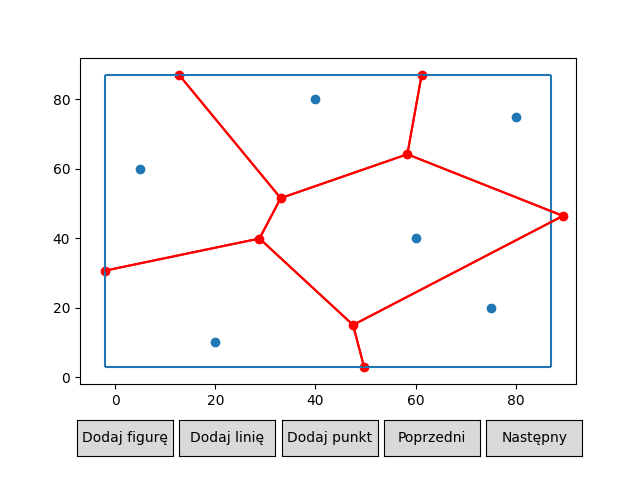

In [21]:
%matplotlib notebook

plot = Plot(scenes=visualization.scenes)


plot.draw(False)